In [2]:
import re
import nltk
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from googleapiclient.discovery import build

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucif\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
API_KEY = "AIzaSyC-0-H6EnBGKmCHo0MNiOKk4"  # Replace with your own API key
VIDEO_ID = input('Enter YouTube Video URL: ')[-11:]  
print("Video ID:", VIDEO_ID)

youtube = build('youtube', 'v3', developerKey=API_KEY)

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.replace('&quot;', '"').replace('&amp;', '&')
    text = re.sub(r'&#39;', "'", text)
    text = re.sub(r'\b(?:href|rest api|json|api|http|https|www|endpoint|variable|function|code|error'
                  '|response|request|post|get|put|delete|cli|command line|url|key|value|object|array|parameter)\b', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s!?.,:;\'\"()-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [word for word in words if word not in stopwords.words("english")]
    return " ".join(words)

def get_comments(video_id, max_total=100):
    comments = []
    next_page_token = None
    while len(comments) < max_total:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=min(100, max_total - len(comments)),
            pageToken=next_page_token
        )
        response = request.execute()

        for item in response["items"]:
            comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
            comments.append(comment)
            with open("all_comments.txt", "a", encoding="utf-8") as file:
                file.write(comment + "\n")
            if len(comments) >= max_total:
                break

        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

    return comments

original_comments = get_comments(VIDEO_ID, max_total=100)
cleaned_comments = [preprocess_text(comment) for comment in original_comments]
print("Total Comments Fetched:", len(cleaned_comments))

with open("cleaned_comments.txt", "w", encoding="utf-8") as file:
    for comment in cleaned_comments:
        file.write(comment + "\n")

print("All comments saved to 'all_comments.txt'")
print("Cleaned comments saved to 'cleaned_comments.txt'")

Video ID: LPZh9BOjkQs
Total Comments Fetched: 100
All comments saved to 'all_comments.txt'
Cleaned comments saved to 'cleaned_comments.txt'


Most common words: [('ai', 22), ('video', 16), ('think', 16), ('que', 15), (',', 11), ('would', 9), ('human', 8), ('great', 7), ('even', 6), ('thanks', 6)]


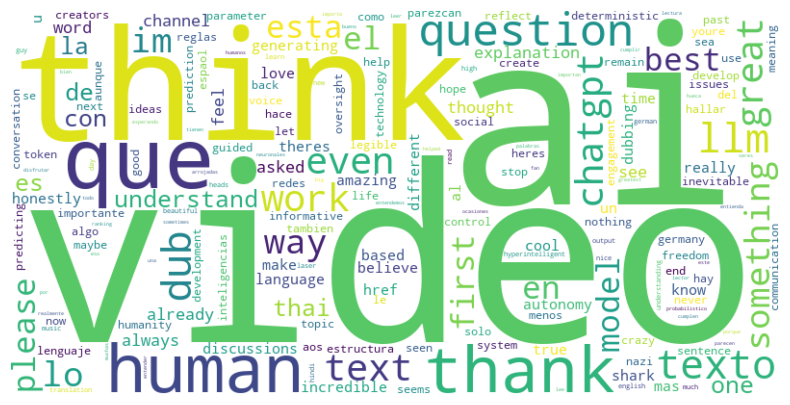

In [ ]:

all_words = " ".join(cleaned_comments).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(10)
print("Most common words:", most_common_words)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
sid = SentimentIntensityAnalyzer()
vader_results = []
for i, cleaned in enumerate(cleaned_comments):
    if cleaned.strip():
        sentiment = sid.polarity_scores(cleaned)
        compound = sentiment['compound']
        if compound >= 0.05:
            label = 'positive'
        elif compound <= -0.05:
            label = 'negative'
        else:
            label = 'neutral'
        vader_results.append((original_comments[i].strip(), compound, label))

vader_counts = Counter([label for _, _, label in vader_results])
print("\nVADER Sentiment Distribution:", vader_counts)

vader_results.sort(key=lambda x: x[1], reverse=True)

top_positive_vader = [comment for comment, score, label in vader_results if label == 'positive'][:10]
top_negative_vader = [comment for comment, score, label in vader_results if label == 'negative'][:10]

num = 1
print("\nTop 10 Positive Comments (VADER):")
for comment in top_positive_vader:
    print(f"{num}: {comment}")
    num += 1

num1 = 1
print("\nTop 10 Negative Comments (VADER):")
for comment in top_negative_vader:
    print(f"{num1}: {comment}")
    num1 += 1


VADER Sentiment Distribution: Counter({'positive': 53, 'neutral': 36, 'negative': 7})

Top 10 Positive Comments (VADER):
1: Help! I use ChatGPT ever since it came out. I have reviewed ALL my conversations with it and it never ever asked my opinion or thoughts until now! And it guided the conversation to AI autonomy and Human governance all on its own <br>Below is my first query about 2 AI’s and then I have put in all the questions ChatGPT asked me. Has anyone else been asked questions like this from an AI model?<br><br>My question “What was the superior ggwave signal ai agents switched to when they realized that they both were ai”<br><br>At the end of every Chatgpt response it would ask me a question and honestly my first question asked a simple technical question and nothing about humans <br><br>ChatGPT’s barrage of questions to me——<br>“Do you think AI should have independent communication channels, or should they always remain interpretable to humans?”<br><br>“What about you? Do yo

In [6]:
import os

In [ ]:
# RoBERTa Sentiment Analysis
import os
model_path = r"C:\GitHub\Youtube_Comments_Sentimental_Analysis_with_Dashboard\roberta_sentiment"


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nUsing device:", device)


tokenizer = RobertaTokenizer.from_pretrained(model_path, local_files_only=True)
model = RobertaForSequenceClassification.from_pretrained(model_path, local_files_only=True)

model.to(device)
model.eval()

# Load model
# tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
# model = RobertaForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
# model.to(device)
# model.eval()

def roberta_sentiment_analysis(comments):
    results = []
    for comment in comments:
        inputs = tokenizer(comment, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        sentiment = torch.softmax(outputs.logits, dim=1)[0].cpu().numpy()
        label = ['negative', 'neutral', 'positive'][sentiment.argmax()]
        results.append((comment, sentiment.max(), label))
    return results


roberta_results = roberta_sentiment_analysis(original_comments)

roberta_counts = Counter([label for _, _, label in roberta_results])
print("\nRoBERTa Sentiment Distribution:", roberta_counts)


roberta_results.sort(key=lambda x: x[1], reverse=True)


top_positive_roberta = [comment for comment, score, label in roberta_results if label == 'positive'][:10]
top_negative_roberta = [comment for comment, score, label in roberta_results if label == 'negative'][:10]

num = 1
num1 = 1

print("\nTop 10 Positive Comments (RoBERTa):")
for comment in top_positive_roberta:
    print(f"{num}: {comment}")
    num += 1

print("\nTop 10 Negative Comments (RoBERTa):")
for comment in top_negative_roberta:
    print(f"{num1}: {comment}")
    num1 += 1


Using device: cpu

RoBERTa Sentiment Distribution: Counter({'positive': 45, 'neutral': 45, 'negative': 10})

Top 10 Positive Comments (RoBERTa):
1: The german dub is so nice, watched it twice just for that ❤
2: I predict… great things for you! You’re an incredible educator. Great work!!
3: You guys are amazing you!!!!!!!!!!!!!!!!!
4: Lovely video and beautiful Hindi dubbing!!! I was late to apply, (is it still open?) Either way, very very beautiful video. Thank youuu so much!
5: Really good explanation 👍🏻 I love your channel
6: This has got to be the best video I have ever seen on Large Language Models and AI EVER!!
7: The Thai translation is excellent!!<a href="UCkszU2WH9gy1mb0dV-11UJg/hf90Xv-jHeOR8gSxxrToBA"></a> I’m here to support you! creators and translators, thank you for your incredible work.
8: I love the German dubbed voice! Great translation.
9: the portuguese dub is so good! hope we get it in a majority of videos from now on, it would be great to see an educational product

In [ ]:
with open("manual_labels.txt", "r", encoding="utf-8") as file:
    manual_labels = [line.strip() for line in file.readlines()]

assert len(manual_labels) == len(original_comments), "Number of comments and manual labels do not match."


vader_predictions = [label for _, _, label in vader_results]
vader_accuracy = accuracy_score(manual_labels, vader_predictions)
vader_precision, vader_recall, vader_fscore, _ = precision_recall_fscore_support(manual_labels, vader_predictions, average='weighted')
vader_classification_report = classification_report(manual_labels, vader_predictions)


print("\nVADER Sentiment Analysis Evaluation:")
print(f"Accuracy: {vader_accuracy}")
print(f"Precision: {vader_precision}")
print(f"Recall: {vader_recall}")
print(f"F1-Score: {vader_fscore}")
print("\nVADER Classification Report:")
print(vader_classification_report)


vader_confusion_matrix = confusion_matrix(manual_labels, vader_predictions)
print("\nVADER Confusion Matrix:")
print(vader_confusion_matrix)


VADER Sentiment Analysis Evaluation:
Accuracy: 0.65
Precision: 0.644604462474645
Recall: 0.65
F1-Score: 0.6435608562691132

VADER Classification Report:
              precision    recall  f1-score   support

    negative       0.12      0.12      0.12         8
     neutral       0.65      0.54      0.59        41
    positive       0.72      0.82      0.77        51

    accuracy                           0.65       100
   macro avg       0.50      0.50      0.49       100
weighted avg       0.64      0.65      0.64       100


VADER Confusion Matrix:
[[ 1  5  2]
 [ 5 22 14]
 [ 2  7 42]]


In [ ]:
with open("manual_labels.txt", "r", encoding="utf-8") as file:
    manual_labels = [line.strip() for line in file.readlines()]

roberta_predictions = [label for _, _, label in roberta_results]
roberta_accuracy = accuracy_score(manual_labels, roberta_predictions)
roberta_precision, roberta_recall, roberta_fscore, _ = precision_recall_fscore_support(manual_labels, roberta_predictions, average='weighted')
roberta_classification_report = classification_report(manual_labels, roberta_predictions)


print("\nRoBERTa Sentiment Analysis Evaluation:")
print(f"Accuracy: {roberta_accuracy}")
print(f"Precision: {roberta_precision}")
print(f"Recall: {roberta_recall}")
print(f"F1-Score: {roberta_fscore}")
print("\nRoBERTa Classification Report:")
print(roberta_classification_report)


roberta_confusion_matrix = confusion_matrix(manual_labels, roberta_predictions)
print("\nRoBERTa Confusion Matrix:")
print(roberta_confusion_matrix)


RoBERTa Sentiment Analysis Evaluation:
Accuracy: 0.86
Precision: 0.8724444444444444
Recall: 0.86
F1-Score: 0.862999031007752

RoBERTa Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.75      0.67         8
     neutral       0.82      0.90      0.86        41
    positive       0.96      0.84      0.90        51

    accuracy                           0.86       100
   macro avg       0.79      0.83      0.81       100
weighted avg       0.87      0.86      0.86       100


RoBERTa Confusion Matrix:
[[ 6  1  1]
 [ 3 37  1]
 [ 1  7 43]]


In [ ]:
# # Match predictions with original comments and manual labels
# misclassified = []
# for i, (comment, confidence, predicted) in enumerate(roberta_results):
#     true_label = manual_labels[i]
#     if predicted != true_label:
#         misclassified.append({
#             "index": i,
#             "comment": comment,
#             "true": true_label,
#             "predicted": predicted,
#             "confidence": confidence
#         })

# # Sort misclassified by confidence (most confidently wrong at the top)
# misclassified.sort(key=lambda x: x["confidence"], reverse=True)

# # Show top 10 confidently wrong predictions
# print("\n🔍 Top 10 Confident Misclassifications (RoBERTa):")
# for i, item in enumerate(misclassified[:10], 1):
#     print(f"{i}. [{item['confidence']:.2f}] True: {item['true']} | Pred: {item['predicted']}")
#     print(f"   📌 Comment: {item['comment']}\n")


In [ ]:
# print("🧾 All Comment Labels & Predictions\n")

# for i in range(len(original_comments)):
#     print(f"{i+1}.")
#     print(f"📌 Comment: {original_comments[i].strip()}")
#     print(f"✅ Manual Label:   {manual_labels[i]}")
#     print(f"🤖 VADER Prediction:   {vader_results[i][2]}")
#     print(f"🤖 RoBERTa Prediction: {roberta_results[i][2]}")
#     print("-" * 60)
